In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Reading data

akbank_data = pd.read_csv(
    "C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\SWE599---Financial-Time-Series-Volatility-and-Return-Forecasting\\Code\\akbank_data.csv")

akbank_data = akbank_data[['Date', 'Hour', 'Open', 'High', 'Low', 'Close']]

#Converting Date and Hour to datetime object and setting it as index. This will help us to plot the data in a time series manner.

akbank_data['Datetime'] = pd.to_datetime(akbank_data['Date'] + " " + akbank_data['Hour'])

#Dropping Date and Hour columns
akbank_data.set_index('Datetime', inplace=True)
akbank_data.drop(['Date', 'Hour'], axis=1, inplace=True)

time_steps = 32


def create_sliding_windows(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)


#Normalizing the data
scaler = MinMaxScaler()
akbank_data_scaled = scaler.fit_transform(akbank_data[['Open', 'High', 'Low', 'Close']])


#Creating sliding windows
X, y = create_sliding_windows(akbank_data_scaled, time_steps)

# #Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Converting the data into torch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


# #Creating the Convolutional Neural Network model class

class StockPricePreditor(nn.Module):
    def __init__(self):
        super(StockPricePreditor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 *5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Swap the dimensions here
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


#Creating the model object
model = StockPricePreditor()

#Defining the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Data loader

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

#Training the model

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #Validating the model

    valid_loss = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            valid_loss += loss.item()

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {valid_loss / len(test_loader)}")

C:\Users\ERALP\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Training Loss: 0.0026462358528005713, Validation Loss: 0.0004561480231491648
Epoch 2/30, Training Loss: 0.00044203277390174865, Validation Loss: 0.0002979980990682043
Epoch 3/30, Training Loss: 0.00035264132111113573, Validation Loss: 0.0003278324143987858
Epoch 4/30, Training Loss: 0.00030098580075619576, Validation Loss: 0.00019012028646057342
Epoch 5/30, Training Loss: 0.000268768989821161, Validation Loss: 0.00031822232558437896
Epoch 6/30, Training Loss: 0.00023441357021569508, Validation Loss: 0.00015838475050551743
Epoch 7/30, Training Loss: 0.0002775085121024438, Validation Loss: 0.0001544372367558163
Epoch 8/30, Training Loss: 0.00017836399471038254, Validation Loss: 0.00016370425507195363
Epoch 9/30, Training Loss: 0.00015415122442095434, Validation Loss: 0.0001025180825858177
Epoch 10/30, Training Loss: 0.00016546788691516393, Validation Loss: 0.00012395070377000267
Epoch 11/30, Training Loss: 0.00015838580833931254, Validation Loss: 0.00010393382187755825
Epoch 

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

# R-squared
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

# Mean squared error
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Root Mean Squared Error
def rmse(y_true, y_pred):
    return math.sqrt(np.mean(y_true, y_pred))

# Mean absolute error
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


0.15347235931013464
10.598182022474928
10.598182030953467


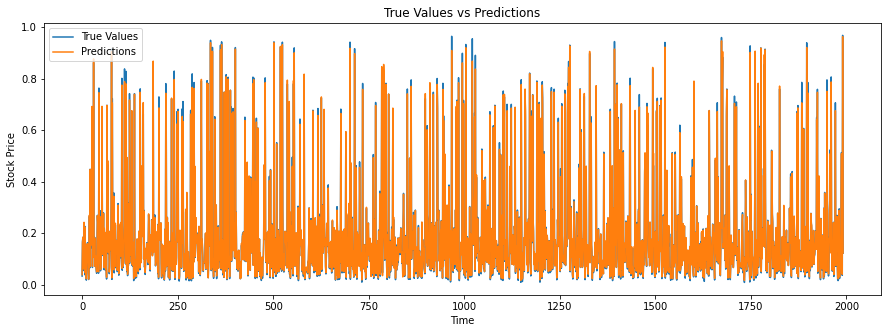

In [13]:
#Evaluating the model
model.eval()
predictions = []
true_values = []
mse_loss = 0.
rmse_loss = 0.
mae_loss = 0.


mse_loss_criterion = nn.MSELoss()
mae_loss_criterion = nn.L1Loss()



with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        mse_loss += mse_loss_criterion(labels, outputs.squeeze()).item()
        rmse_loss += math.sqrt(mse_loss_criterion(labels, outputs.squeeze()).item())
        mae_loss += mae_loss_criterion(labels, outputs.squeeze()).item()
        predictions.append(outputs.item())
        true_values.append(labels.item())
        
# rmse_loss = rmse(y_true=true_values, y_pred=predictions)
# mse_loss = mse(y_true=np.array(true_values), y_pred=np.array(predictions))
# mae_loss = mae(y_true=np.array(true_values), y_pred=np.array(predictions))
# rsquared_loss = r_squared(y_true=np.array(true_values), y_pred=np.array(predictions))
print(mse_loss)
print(rmse_loss)
print(mae_loss)


# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [11]:
np.array(predictions).shape, type(np.array(predictions))

C:\Users\ERALP\AppData\Local\Temp\ipykernel_8732\2691649651.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(predictions).shape, type(np.array(predictions))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1992,) + inhomogeneous part.

In [10]:
import numpy as np
true_values.min()

AttributeError: 'list' object has no attribute 'min'

In [ ]:
!pip show numpy